This notebook presents an attempt to isolate the `gaussian_kde` code in scipy and speed it up for computing log volume fractions.

## minimal working KDE example

In [1]:
import numpy as np
import scipy

from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import cm

import copy

In [2]:
np.random.seed(0)

In [3]:
EPSILON = .025
M       = 1e-21
T_R     = 4e5
K_B     = scipy.constants.Boltzmann
TAU     = 10.

L     = 400
Q_MIN = np.array([0., 0.  ])
Q_MAX = np.array([L , L/5.])

p_max = M * np.abs(Q_MAX - Q_MIN) / EPSILON

loc   = 0.
scale = np.sqrt(M * K_B * T_R) / EPSILON
# scale = np.sqrt(K_B * T_R)

timesteps = int(TAU / EPSILON)

In [4]:
q = np.array([L/10., L/10.])
p = np.array([0.   , 0.   ])

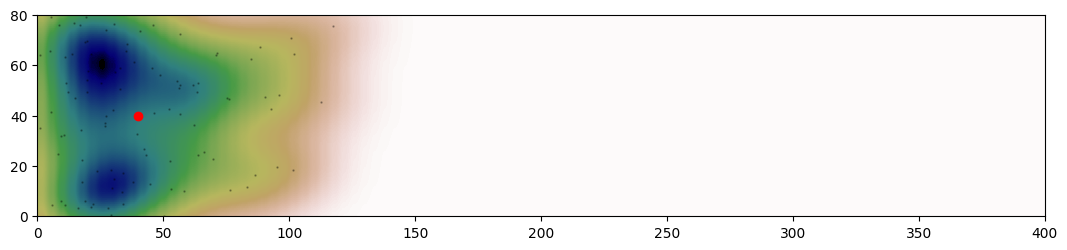

In [5]:
# create array of (timesteps, num_samples, q_dim)

num_samples = 100
qs = np.tile(q[None, :], (num_samples, 1))
ps = np.tile(p[None, :], (num_samples, 1))

paths  = copy.deepcopy(qs[None, :])
all_fs = np.zeros((timesteps, num_samples, 2))

# create MC rollouts producing array (timesteps, num_samples, q_dim)
for i in range(timesteps-1):
    fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
    gs = - ps / EPSILON + fs

    all_fs[i] = fs

    p_dots = gs
    ps    += p_dots * EPSILON
    # bound the momentum by the maximum momentum
    # ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
    
    q_dots = ps / M
    qs    += q_dots * EPSILON
    # perfectly elastic collisions with walls
    qs  = np.maximum(qs, 2 * Q_MIN - qs)
    ps *= np.sign(qs - Q_MIN)
    qs  = np.minimum(qs, 2 * Q_MAX - qs)
    ps *= np.sign(Q_MAX - qs)

    paths = np.append(paths, qs[None, :], axis=0)


# plot kde of the endpoints and scatter of the endpoints
# Adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

kernel = scipy.stats.gaussian_kde(paths[-1].T)

# estimate pdf
X, Y      = np.mgrid[Q_MIN[0]:Q_MAX[0]:100j, Q_MIN[1]:Q_MAX[1]:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z         = np.reshape(kernel(positions), X.shape)

# plot
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[Q_MIN[0], Q_MAX[0], Q_MIN[1], Q_MAX[1]])
ax.scatter(*paths[-1].T, color='k', s=.5, alpha=.3)
ax.scatter(*q, color='r')
ax.set(aspect='equal')
plt.show()

### compute KDE pdfs from scipy

In [6]:
points = paths[-1].T
kernel = scipy.stats.gaussian_kde(points)
pdfs   = kernel.pdf(points)

In [7]:
pdfs

array([1.24164355e-04, 6.01326308e-05, 1.24654415e-04, 9.00537096e-05,
       1.43557154e-04, 3.38641769e-05, 5.38384829e-05, 1.54769904e-04,
       8.27864620e-05, 1.48393322e-04, 1.04953968e-04, 1.27739084e-04,
       1.18453432e-04, 1.66244232e-04, 4.36218265e-05, 1.36576613e-04,
       7.52098727e-05, 7.77473069e-05, 1.39326891e-04, 9.37929588e-05,
       1.62765073e-04, 7.48293388e-05, 1.44094537e-04, 1.70554908e-04,
       1.37505703e-04, 1.18779823e-04, 1.28895417e-04, 6.77531124e-05,
       1.51838447e-04, 1.56044042e-04, 1.07147203e-04, 1.23414618e-04,
       1.26597876e-04, 1.34196634e-04, 1.54599923e-04, 7.80629139e-05,
       1.42398135e-04, 9.28365705e-05, 1.63017909e-04, 1.45292584e-04,
       4.59382761e-05, 1.19222529e-04, 1.35591960e-04, 1.27645615e-04,
       5.57570160e-05, 1.37015089e-04, 8.31317217e-05, 1.47807981e-04,
       1.61894986e-04, 2.60878826e-05, 1.37899252e-04, 1.25464097e-04,
       5.52199423e-05, 7.62268009e-05, 6.73029682e-05, 1.12266154e-04,
      

### compute KDE pdfs from copy of scipy code

In [8]:
# -------------------------------------------------------------------------------
#
#  Define classes for (uni/multi)-variate kernel density estimation.
#
#  Currently, only Gaussian kernels are implemented.
#
#  Written by: Robert Kern
#
#  Date: 2004-08-09
#
#  Modified: 2005-02-10 by Robert Kern.
#              Contributed to SciPy
#            2005-10-07 by Robert Kern.
#              Some fixes to match the new scipy_core
#
#  Copyright 2004-2005 by Enthought, Inc.
#
# -------------------------------------------------------------------------------

import numpy as np

from scipy import linalg
from scipy.stats._stats import gaussian_kernel_estimate


class gaussian_kde:
    def __init__(self, dataset):
        self.dataset = np.atleast_2d(np.asarray(dataset))
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")

        self.d, self.n = self.dataset.shape
        self.weights = np.ones(self.n) / self.n

        # This can be converted to a warning once gh-10205 is resolved
        if self.d > self.n:
            msg = ("Number of dimensions is greater than number of samples. "
                   "This results in a singular data np.covariance matrix, which "
                   "cannot be treated using the algorithms implemented in "
                   "`gaussian_kde`. Note that `gaussian_kde` interprets each "
                   "*column* of `dataset` to be a point; consider transposing "
                   "the input to `dataset`.")
            raise ValueError(msg)

        try:
            # this is scotts_factor
            neff = 1 / np.sum(self.weights ** 2)
            self.factor = np.power(neff, -1. / (self.d + 4))
            # Cache np.covariance and Cholesky decomp of np.covariance
            if not hasattr(self, '_data_cho_np.cov'):
                cov = np.cov(self.dataset, rowvar=1, bias=False, aweights=self.weights)
                self._data_covariance = np.atleast_2d(cov)
                self._data_cho_cov = linalg.cholesky(self._data_covariance, lower=True)

            self.covariance = self._data_covariance * self.factor ** 2
            self.cho_cov = (self._data_cho_cov * self.factor).astype(np.float64)
            self.log_det = 2 * np.log(np.diag(self.cho_cov * np.sqrt(2 * np.pi))).sum()
        except linalg.LinAlgError as e:
            msg = ("The data appears to lie in a lower-dimensional subspace "
                   "of the space in which it is expressed. This has resulted "
                   "in a singular data np.covariance matrix, which cannot be "
                   "treated using the algorithms implemented in "
                   "`gaussian_kde`. Consider performing principle component "
                   "analysis / dimensionality reduction and using "
                   "`gaussian_kde` with the transformed data.")
            raise linalg.LinAlgError(msg) from e

    def evaluate(self, points):
        points = np.atleast_2d(np.asarray(points))
        output_dtype, spec = _get_output_dtype(self.covariance, points)
        result = gaussian_kernel_estimate[spec](
            self.dataset.T, self.weights[:, None], points.T, self.cho_cov, output_dtype
        )

        return result[:, 0]


def _get_output_dtype(covariance, points):
    """
    Calculates the output dtype and the "spec" (=C type name).

    This was necessary in order to deal with the fused types in the Cython
    routine `gaussian_kernel_estimate`. See gh-10824 for details.
    """
    output_dtype = np.common_type(covariance, points)
    itemsize = np.dtype(output_dtype).itemsize
    if itemsize == 4:
        spec = 'float'
    elif itemsize == 8:
        spec = 'double'
    elif itemsize in (12, 16):
        spec = 'long double'
    else:
        raise ValueError(f"{output_dtype} has unexpected item size: {itemsize}")

    return output_dtype, spec

In [9]:
my_kernel = gaussian_kde(points)
my_pdfs   = my_kernel.evaluate(points)

In [10]:
np.all(pdfs == my_pdfs)

np.True_

### Now try higher dimensional KDE

In [11]:
# create array of (timesteps, num_samples, q_dim)

num_samples = 100_000
qs = np.tile(q[None, :], (num_samples, 1))
ps = np.tile(p[None, :], (num_samples, 1))

paths  = copy.deepcopy(qs[None, :])
all_fs = np.zeros((timesteps, num_samples, 2))

# create MC rollouts producing array (timesteps, num_samples, q_dim)
for i in range(timesteps-1):
    fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
    gs = - ps / EPSILON + fs

    all_fs[i] = fs

    p_dots = gs
    ps    += p_dots * EPSILON
    # bound the momentum by the maximum momentum
    # ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
    
    q_dots = ps / M
    qs    += q_dots * EPSILON
    # perfectly elastic collisions with walls
    qs  = np.maximum(qs, 2 * Q_MIN - qs)
    ps *= np.sign(qs - Q_MIN)
    qs  = np.minimum(qs, 2 * Q_MAX - qs)
    ps *= np.sign(Q_MAX - qs)

    paths = np.append(paths, qs[None, :], axis=0)

# remove the first state because we calculate conditional density
paths = paths[1:]

In [15]:
flat_paths = paths.swapaxes(0, 1).reshape(-1, num_samples)

# hd_kernel = gaussian_kde(flat_paths)
# hd_pdfs   = hd_kernel.evaluate(flat_paths)

In [13]:
# hd_pdfs

find the source of slowness, first in constructing the kernel

In [16]:
dataset = flat_paths

In [17]:
dataset = np.atleast_2d(np.asarray(dataset))

In [18]:
d, n = dataset.shape
weights = np.ones(n) / n

In [19]:
# this is scotts_factor
neff = 1 / np.sum(weights ** 2)
factor = np.power(neff, -1. / (d + 4))

In [20]:
cov = np.cov(dataset, rowvar=1, bias=False, aweights=weights)
_data_covariance = np.atleast_2d(cov)
_data_cho_cov = linalg.cholesky(_data_covariance, lower=True)

In [21]:
covariance = _data_covariance * factor ** 2
cho_cov = (_data_cho_cov * factor).astype(np.float64)
log_det = 2 * np.log(np.diag(cho_cov * np.sqrt(2 * np.pi))).sum()

then in the evaluation

In [22]:
points = flat_paths

In [23]:
points = np.atleast_2d(np.asarray(points))
output_dtype, spec = _get_output_dtype(covariance, points)

In [ ]:
result = gaussian_kernel_estimate[spec](dataset.T, weights[:, None], points.T, cho_cov, output_dtype)

the slowness is in the last line -- unfortunately, I have no idea what the code is for this line